In [ ]:
#  pip install keras-cv==0.4.0
#  pip install tensorflow-datasets

import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

# tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Stable-Diffusion Model
<img src='model.png' />
    
The Stable Diffusion architecture consists of three blocks::

* **Text Encoder**: Converts the text description into a vector.
* **Diffusion Model**: Repeatedly removes noise from a fragment of latent information to generate the encoder's output vector necessary for image reconstruction.
* **Decoder**: Transforms an encoding in the latent space of the final image, with dimensions 4x64×64, into an image with a resolution of 512×512 over 3 color channels.
    
The textual description is then projected into an eigenvector in a predetermined dimensional space, through a linguistic model with "frozen weights."
The eigenvector is then associated with a randomly generated noise block which, passing through the "noise removal" iterations in the decoder, is decoded into the input necessary for generating an image.
By default, 50 denoising steps are performed. Increasing/decreasing the number of steps yields more/less defined images and more/less adherence to the input tokens.
By default, 50 iterations are executed.
The generated latent image is finally "decoded" into a higher-resolution image.   

-----
    
### Diffusion Model - Operation    
    
The underlying concept of Diffusion architectures' operation is that by constructing a learning model to learn the systematic decay of information due to noise, it is possible to reverse the process and thus recover the original information from the noise.
This concept is similar to that underlying VAEs (Variational AutoEncoders) as it attempts to optimize a cost function by first projecting the data onto the latent space and then recovering it towards the initial state.
However, instead of learning the data distribution, the system aims to model a series of noise distributions in a Markov chain and "decodes" the data by attempting to undo the steps taken on the data hierarchically.  
     
<img src='diffusion_model.png' />    
    
The main innovation brought by the Stable Diffusion architecture is to operate the diffusion process in the latent space rather than in the pixel space, achieving faster generation by working on a lower number of parameters.  
    

-----
    
### Stable Diffusion Architecture   
    
Below is a diagram of how the model training is conducted:
An image **x** is provided to the model, encoded into the model's latent space, then multiple diffusion steps are applied to create new examples that need to be "cleaned" from the noise through the U-Net block.
The final result, in the model's latent space, is decoded into pixel space and compared with the initial image.
It's worth noting that the denoising process is driven by a series of external information that influences the generation of the output itself, including the text describing the input image.    
    
<img src='latent-diffusion-arch.png' />    

# Stable Diffusion 2 in Keras

### Examples of using the pre-trained model.

In [2]:
model = keras_cv.models.StableDiffusionV2(img_height=512, img_width=512, jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL++-M license at https://github.com/Stability-AI/stablediffusion/main/LICENSE-MODEL


50/50 [==============================] - 249s 673ms/step


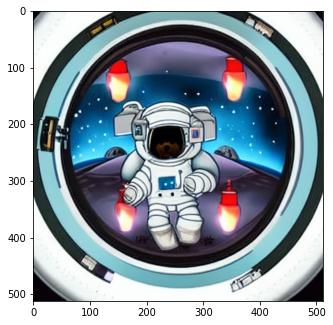

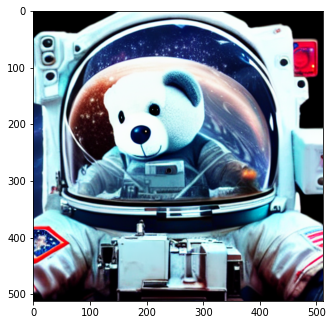

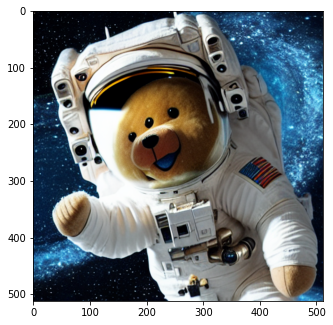

In [3]:
examples = 3

imgs = model.text_to_image(
    prompt='an astronaut teddy bear inside a spaceship traveling in the universe',
    batch_size=examples,
    num_steps=50,
    seed=4242,
)

for i in range(examples):
    plt.figure(figsize=(512/96, 512/96))
    plt.imshow(imgs[i])
    plt.show()

31/31 [==============================] - 21s 679ms/step


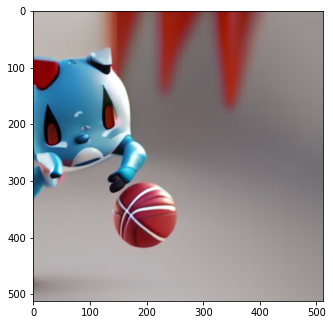

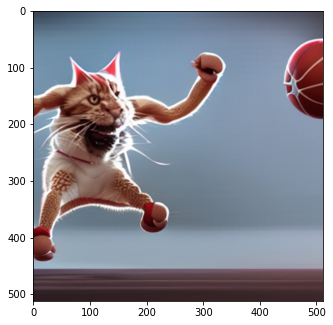

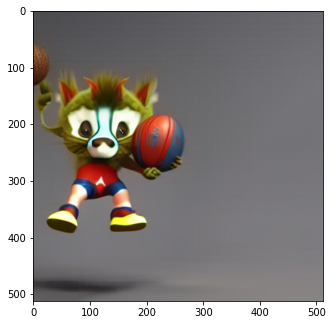

In [4]:
examples = 3

imgs = model.text_to_image(
    prompt='a cute super-hero pet playing basketball, highly detailed, ultra resolution, rendering, 4k, 8k',
    batch_size=examples,
    num_steps=30,
    seed=4242,
)

for i in range(examples):
    plt.figure(figsize=(512/96, 512/96))
    plt.imshow(imgs[i])
    plt.show()

In [5]:
# Method to build a GIF animation
# starting from a list of PIL images

def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:  # create a loop in the final animation, copying into the image list,
                     # from the second to the penultimate image in reverse order
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

31/31 [==============================] - 21s 671ms/step


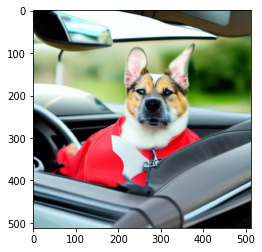

31/31 [==============================] - 32s 1s/step


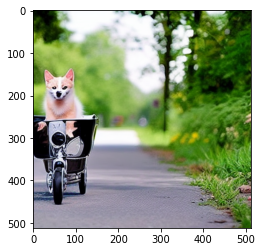

31/31 [==============================] - 33s 1s/step


In [6]:
# transition between two latent vectors corresponding to two different texts

prompt_1 = 'a cute pet drives a car'
prompt_2 = 'a cute pet rides a bike'

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

walk_steps = 50
batch_size = 3
batches = walk_steps // batch_size
interpolated_encodings = tf.linspace(encoding_1, encoding_2, walk_steps)
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=42)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            interpolated_encodings[batch * batch_size:(batch * batch_size) + batch_size],
            batch_size=batch_size,
            num_steps=30,
            diffusion_noise=noise,
        )
    ]
    if batch % 10 == 0:
        plt.imshow(images[-1])
        plt.show()

    
export_as_gif('cute_pet_v2_1.gif', images, rubber_band=True, frames_per_second=8)

In [3]:
# from IPython.display import Image

# Image(filename=r'C:\Users\reand\Desktop\cute_pet_v2_1.gif')

31/31 [==============================] - 80s 1s/step


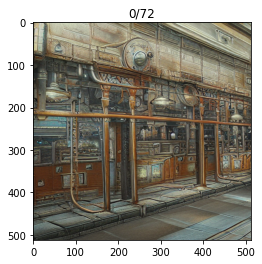

31/31 [==============================] - 50s 2s/step


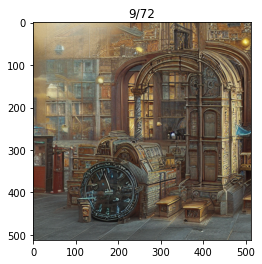

31/31 [==============================] - 51s 2s/step


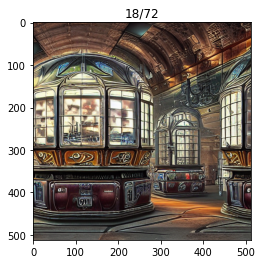

31/31 [==============================] - 60s 2s/step


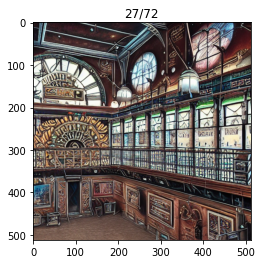

31/31 [==============================] - 53s 2s/step


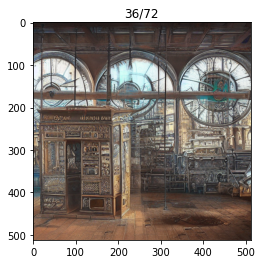

31/31 [==============================] - 54s 2s/step


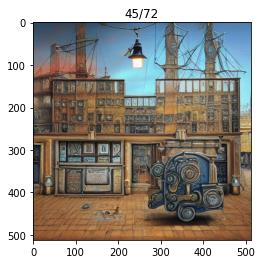

31/31 [==============================] - 60s 2s/step


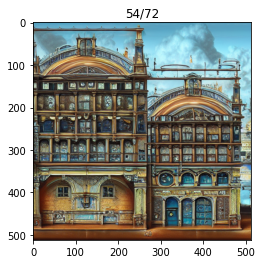

31/31 [==============================] - 52s 2s/step


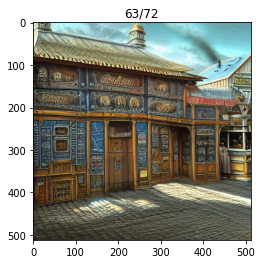

31/31 [==============================] - 60s 2s/step


In [7]:
# animation of the outputs obtained through transition
# in the vicinity of the latent vector of the input text

prompt = 'time machine between ages, photorealistic, higly detailed, high quality, old and new, lights and shadows'

noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=42)
encoding = tf.squeeze(model.encode_text(prompt))
walk_steps = 360
batch_size = 5
batches = walk_steps // batch_size

walk_noise_x = tf.random.normal(noise.shape, dtype=tf.float64, seed=42)
walk_noise_y = tf.random.normal(noise.shape, dtype=tf.float64, seed=24)

walk_scale_x = tf.cos(tf.linspace(0, 2, walk_steps) * np.pi)
walk_scale_y = tf.sin(tf.linspace(0, 2, walk_steps) * np.pi)
noise_x = tf.tensordot(walk_scale_x, walk_noise_x, axes=0)
noise_y = tf.tensordot(walk_scale_y, walk_noise_y, axes=0)
noise = tf.add(noise_x, noise_y)
batched_noise = tf.split(noise, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encoding,
            batch_size=batch_size,
            num_steps=30,
            diffusion_noise=batched_noise[batch]
        )
    ]
    if batch % 9 == 0:
        plt.title(str(batch) + '/' + str(batches))
        plt.imshow(images[-batch_size])
        plt.show()
        
export_as_gif('time_machine_v2_1.gif', images, frames_per_second=15)

In [2]:
# Image(filename=r'C:\Users\reand\Desktop\time_machine_v2_1.gif')


250/250 [==============================] - 276s 1s/step


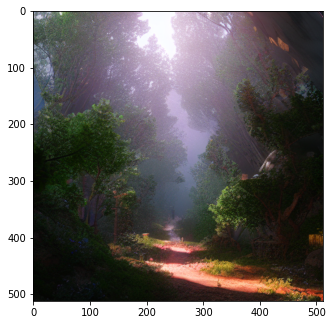

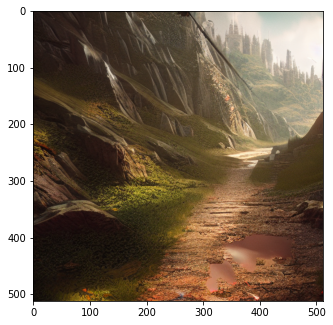

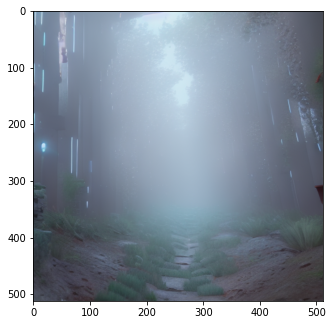

In [8]:
# generation of images over multiple steps (250)
# for better final quality and increased
# adherence to all tokens passed
# in the textual input

examples = 3

imgs = model.text_to_image(
    prompt='A trail through the unknown, atmospheric, dreamy, hyper realistic, 8k, 4k, epic composition, high resolution, post processing, highly detailed, rendering, romantic, unreal, maya',
    batch_size=examples,
    num_steps=250,
    seed=42,
)

for i in range(examples):
    plt.figure(figsize=(512/96, 512/96))
    plt.imshow(imgs[i])
    plt.show()

In [9]:
# visualization of how the number
# of steps affects image generation

prompt = 'a cyclist on a blue bike drinks a coke while pedaling in Central Park among a few happy strolling people on a sunny day, photorealistic'
encoding = tf.squeeze(model.encode_text(prompt))
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=42)

steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 350]

images = []
for i in range(len(steps)):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encoding,
            batch_size=1,
            num_steps=steps[i],
            diffusion_noise=noise
        )
    ]

font = ImageFont.truetype('FONTS/arial.ttf', 32)
for i, image in enumerate(images):
    ImageDraw.Draw(
        image               
    ).text(
        (8, 8),             # Coordinates to place the text
        str(steps[i]),      # Text string
        (255, 255, 255),    # RGB color
        font=font           # Font and text size
    )
    images[i] = image

export_as_gif('steps_test_v2_1.gif', images, frames_per_second=1)

500/500 [==============================] - 238s 476ms/step


In [1]:
# Image(filename=r'C:\Users\reand\Desktop\steps_test_v2_1.gif')


### In-Painting
(remember to disable Mixed-Precision to make the in-painting process work)

In [3]:
im = Image.open('cowboy.jpg')
img = np.array(im)

In [4]:
x_start = 230
x_end = 340
y_start = 186
y_end = 397

In [5]:
mask = np.ones((img.shape[:2]))
# Apply mask
mask[y_start:y_end, x_start:x_end] = 0

In [6]:
mask = np.expand_dims(mask, axis=0)
img = np.expand_dims(img, axis=0)

In [7]:
inpaint_options = dict(
        prompt='An astronaut riding a horse',
        image=img,  # RGB tensor values scaled between [0, 255]. Tensor dimensions: (batch_size, H, W, 3)
        mask=mask,  # binary mask values (0 or 1)
        mask=mask,  
        num_resamples=5,
        batch_size=1,
        num_steps=150,
        unconditional_guidance_scale=8.5,
        diffusion_noise=None,
        seed=4242,
        verbose=True,
)

In [8]:
inpainted = model.inpaint(**inpaint_options)

Image.fromarray(inpainted[0]).save('inpainted.png')

167/167 [==============================] - 603s 3s/step


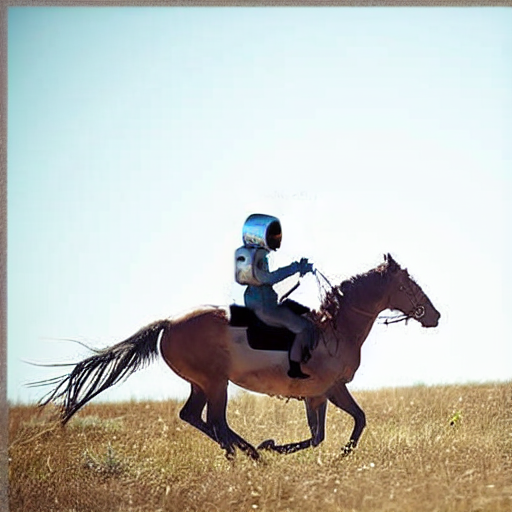

In [3]:
Image(filename=r'C:\Users\reand\Desktop\inpainted.png')